<a href="https://colab.research.google.com/github/diliprk/MasterThesis-ML4ACADS/blob/master/CycleGAN_ToyProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t8T2qHhpPoOYQX_M5lMsCs3IzSNd5cNH#scrollTo=uy9t6CKDGBwu)

## Version Description:
In this version we experiment with a toy problem to understand the application of CycleGANs for our requirement.<br> The CycleGAN generates the following columns (i.e all major features):
* `D` - (Restrictor Diameter) 
* `z` - (Loss Co-efficient)
* `c` - (Correction Factor)
* `V` - (Volume Flow Rate)
<br>Derived features like `A` (Area) and `zc` (z * c) are ommitted to avoid redundant feature selection and improve model performance.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import random
import pandas as pd
import numpy as np
from math import pi
from numpy.random import rand, randn, randint
from functools import reduce

#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=3, edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.3g" % x))

# Disable Warnings for chained assignments Eg:Setting with Copy Warning
pd.options.mode.chained_assignment = None 

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn-whitegrid')

### Generate Data points for Toy Dataset:

In [0]:
## Constant parameters from a lab test bench
D1 = 120
dp = 26
D_duct = 180
A_duct = pi/4*(D_duct/1000)**2
increment = 1.02

In [0]:
def gen_new_points(dia,cf_error=[],cf_flag = 1):
    '''Custom function to generate data points of different distributions to construct toy dataset.
    Setting the c_f flag to various values generates points for data distributions in the toy dataset.
    c_f flag = 1 generates points for the LTR dataset,
    c_f flag = 0 generates simulation points with systematic error
    c_f flag = -1 generates erroneous points for the LTR dataset which requires erroenous values in cf_error list
    '''
    A_d = pi/4*(dia/1000)**2 
    z = (1 - (A_d / A_duct))**2 
    x2 = ((dia - D1) / 2) + 1
    if cf_flag == 1:
        # C_f for LTR points
        cf = 1 * (increment**(x2 - 1))
    elif cf_flag == 0:
        # C_f for Sim points
        cf = 1
    elif cf_flag == -1:
        # C_f for manually generating erroneous points 
        cf = cf_error
    zc = z * cf
    V = ((dp/zc) * (A_duct)**2)**0.5
    return A_d,z,cf,zc,V   

In [6]:
# Create a toy dataset of 'real world points' using the lab test parameters
dia_array = range(120,162,1)
area, zeta, cf, zeta_cf, V_flowrate = gen_new_points(np.array(dia_array))
toy_df = pd.DataFrame({'D':dia_array,'A':area,'Z':zeta,'c':cf,'Zc':zeta_cf,'V':V_flowrate})
# toy_df.to_csv('data/Toy_DataSet.csv', index = False)
toy_df

,D,A,Z,c,Zc,V
0,120,0.011310,0.308642,1.000000,0.308642,0.233558
1,121,0.011499,0.300433,1.009950,0.303422,0.235558
2,122,0.011690,0.292267,1.020000,0.298112,0.237647
3,123,0.011882,0.284148,1.030150,0.292715,0.239827
4,124,0.012076,0.276079,1.040400,0.287232,0.242106
5,125,0.012272,0.268062,1.050752,0.281667,0.244486
6,126,0.012469,0.260100,1.061208,0.276020,0.246974
7,127,0.012668,0.252196,1.071768,0.270296,0.249576
8,128,0.012868,0.244353,1.082432,0.264496,0.252297
9,129,0.013070,0.236574,1.093203,0.258624,0.255145


In [7]:
# Select some points from the toy_df (from reality) to represent the lab test data points 
dia_LTR = [120,126,132,138,142]
dataset_LTR = toy_df[['D','Z','c','V']].loc[toy_df['D'].isin(dia_LTR)]
dataset_LTR.reset_index(drop = True, inplace = True)
dataset_LTR

,D,Z,c,V
0,120,0.308642,1.000000,0.233558
1,126,0.260100,1.061208,0.246974
2,132,0.213649,1.126162,0.264527
3,138,0.169927,1.195093,0.287932
4,142,0.142623,1.243374,0.308124


In [8]:
# Introduce some error (non-linearities) by using wrong c_f in LTR datapoints to create outliers
dia_ep = [132] #[132,146,155]
cf_err = [0.9] #[0.9, 0.78, 0.92]

area_ep, zeta_ep, cf_ep, zeta_cf_ep, V_flowrate_ep = gen_new_points(np.array(dia_ep),cf_error = cf_err, cf_flag = -1)
df_ep = pd.DataFrame({'D':dia_ep,'A':area_ep,'Z':zeta_ep,'c':cf_ep,'Zc':zeta_cf_ep,'V':V_flowrate_ep})
df_ep['Zc_delta'] = df_ep['Zc'].values - toy_df['Zc'].loc[toy_df['D'].isin(dia_ep)].values
df_ep['V_delta'] = df_ep['V'].values - toy_df['V'].loc[toy_df['D'].isin(dia_ep)].values
df_ep['%Error'] = 100 * df_ep['V_delta'].values/toy_df['V'].loc[toy_df['D'].isin(dia_ep)].values
df_ep = df_ep[['D','A','Z','c','Zc','Zc_delta','V','V_delta','%Error']]
print('Synthesised Erroneous Points:')
df_ep

Synthesised Erroneous Points:


,D,A,Z,c,Zc,Zc_delta,V,V_delta,%Error
0,132,0.013685,0.213649,0.9,0.192284,-0.048319,0.295903,0.031376,11.861145


In [9]:
# Replace corresponding data point in dataset_LTR with outlier point
idx_2drop = dataset_LTR.loc[dataset_LTR['D'].isin(dia_ep)].index.tolist()
print('Indices to Drop in LTR_Dataset:',idx_2drop, 'with Dia values:',dia_ep) #,'Data Type:',type(idx_2drop)
dataset_LTR.drop(idx_2drop,inplace = True)
dataset_LTR = dataset_LTR.append(df_ep[['D','Z','c','V']])
dataset_LTR.sort_values(by=['D'], ascending=[1], inplace = True)
dataset_LTR.reset_index(drop = True,inplace = True)
dataset_LTR

Indices to Drop in LTR_Dataset: [2] with Dia values: [132]


,D,Z,c,V
0,120,0.308642,1.000000,0.233558
1,126,0.260100,1.061208,0.246974
2,132,0.213649,0.900000,0.295903
3,138,0.169927,1.195093,0.287932
4,142,0.142623,1.243374,0.308124


In [10]:
# Create low-fidelity simulated points for the same diamter values in the toy_df
# To introduce some systematic error into the simulation points we set the c_f == 1 which deviates it from the real world points
dia_sim = range(120,144,2) 
area_sim, zeta_sim, cf_sim, Zeta_cf_sim, V_flowrate_sim = gen_new_points(np.array(dia_sim), cf_flag = 0)
dataset_sim = pd.DataFrame({'D':dia_sim,'A':area_sim,'Z':zeta_sim,'c':cf_sim,'Zc':Zeta_cf_sim,'V':V_flowrate_sim})
dataset_sim['Zc_delta'] = dataset_sim['Zc'] - toy_df['Zc']
dataset_sim['V_delta'] = dataset_sim['V'] - toy_df['V']
dataset_sim['%Error'] = 100 * dataset_sim['V_delta']/toy_df['V']
dataset_sim = dataset_sim[['D','A','Z','c','Zc','Zc_delta','V','V_delta','%Error']]
# toy_df_simulation.to_csv('data/Toy_DataSet_Simulation.csv', index = False)
dataset_sim

,D,A,Z,c,Zc,Zc_delta,V,V_delta,%Error
0,120,0.011310,0.308642,1,0.308642,0.000000,0.233558,0.000000,0.000000
1,122,0.011690,0.292267,1,0.292267,-0.011155,0.240011,0.004453,1.890481
2,124,0.012076,0.276079,1,0.276079,-0.022033,0.246948,0.009301,3.913844
3,126,0.012469,0.260100,1,0.260100,-0.032615,0.254420,0.014593,6.084620
4,128,0.012868,0.244353,1,0.244353,-0.042879,0.262490,0.020384,8.419580
5,130,0.013273,0.228862,1,0.228862,-0.052805,0.271228,0.026742,10.938182
6,132,0.013685,0.213649,1,0.213649,-0.062371,0.280718,0.033744,13.663130
7,134,0.014103,0.198740,1,0.198740,-0.071556,0.291058,0.041482,16.621082
8,136,0.014527,0.184158,1,0.184158,-0.080338,0.302362,0.050065,19.843544
9,138,0.014957,0.169927,1,0.169927,-0.088696,0.314768,0.059622,23.368031


In [0]:
dataset_sim = dataset_sim[['D','Z','c','V']] # Omit columns not needed for the ML

### Rescale and Normalize Data:

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # Common MinMaxScaler for all features.

In [13]:
# Create copies of the two datasets for scaling purpose
Sim_df = dataset_sim.copy()
LTR_df = dataset_LTR.copy()
LTR_df

,D,Z,c,V
0,120,0.308642,1.000000,0.233558
1,126,0.260100,1.061208,0.246974
2,132,0.213649,0.900000,0.295903
3,138,0.169927,1.195093,0.287932
4,142,0.142623,1.243374,0.308124


In [14]:
Sim_df.sort_values(by=['D'], ascending=[True], inplace = True)
Sim_df

,D,Z,c,V
0,120,0.308642,1,0.233558
1,122,0.292267,1,0.240011
2,124,0.276079,1,0.246948
3,126,0.260100,1,0.254420
4,128,0.244353,1,0.262490
5,130,0.228862,1,0.271228
6,132,0.213649,1,0.280718
7,134,0.198740,1,0.291058
8,136,0.184158,1,0.302362
9,138,0.169927,1,0.314768


In [0]:
# Rescale Data
colnames_all = list(LTR_df)
LTR_df[colnames_all] = scaler.fit_transform(LTR_df[colnames_all])
Sim_df[colnames_all] = scaler.fit_transform(Sim_df[colnames_all])

In [16]:
print('No. of columns in LTR dataframe :',LTR_df.shape[1])
print('No. of columns in FDDN dataframe:',Sim_df.shape[1])

No. of columns in LTR dataframe : 4
No. of columns in FDDN dataframe: 4


In [17]:
from keras.optimizers import Adam
from keras.models import Model, Sequential, Input
from keras.layers import Dense, LeakyReLU, Activation
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# Select a batch of random samples, returns features and target
def generate_real_samples(dataset, n_samples):
    # choose random instances of indices
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve samples from indices
    X = dataset.iloc[ix].values
    # generate 'real' class labels (1)
    y = np.ones((n_samples,1))
    return X, y

In [0]:
# generate a batch of fake examples with class labels
def generate_fake_samples(gen_model, dataset):
    # generate fake instance
    X = gen_model.predict(dataset)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),1))
    return X, y

### Define Architecture of Generator and Discriminator

In [0]:
# define the discriminator model
def define_discriminator(nr_features):
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    model.add(Dense(nr_features, activation='relu',kernel_initializer=init, input_shape=(nr_features,)))
    model.add(Dense(32, activation='relu',kernel_initializer=init))
    model.add(Dense(1, activation='linear'))
    # COMPILE Model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
#     model.compile(loss='binary_crossentropy', optimizer='adam')
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model
 
 # define the standalone generator model
def define_generator(nr_features):
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    model.add(Dense(nr_features, activation='relu',kernel_initializer=init, input_shape=(nr_features,)))
    model.add(Dense(32, activation='relu',kernel_initializer=init))  
    model.add(Dense(nr_features, activation='linear'))
    return model

In [21]:
# Define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, nr_features):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=(nr_features,))
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=(nr_features,))
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mse', 'mse', 'mse'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

nr_features = LTR_df.shape[1]
# generator: A -> B
g_model_AtoB = define_generator(nr_features)
# generator: B -> A
g_model_BtoA = define_generator(nr_features)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(nr_features)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(nr_features)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, nr_features)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, nr_features)

In [0]:
# Generate samples and save as a plot and save the model
def summarize_performance(epoch_step, g_model, trainX, name):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples = 32)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model_BtoA, X_in)
    # Inverse scale to real value
    X_in = scaler.inverse_transform(X_in)
    X_out = scaler.inverse_transform(X_out)
    # Scatter plot of real and fake data points
    plt.scatter(X_in[:, 0], X_in[:, -1], color='red',label = 'Real Data')
    plt.scatter(X_out[:, 0], X_out[:, -1], color='blue', label = 'Synthesized Data')
    plt.ylabel("R600_HD")
    plt.xlabel("TZ6_Flow")
    plt.legend(loc="upper left")
    plt.show()
  # save plot every set epoch_steps to file
#   filename1 = '%s_generated_plot_%06d.png' % (name, (epoch_step+1))
#   plt.savefig(filename1)  

In [0]:
# Update simulation pool for fake datapoints
def update_sim_pool(pool, data_points, max_size=5):
    selected = list()
    for data in data_points:
        if len(pool) < max_size:
            # stock the pool
            pool.append(data)
            selected.append(data)
        elif random.random() < 0.5:
            # use data point, but don't add it to the pool
            selected.append(data)
        else:
            # replace an existing data point and use replaced data point
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = data
    return np.asarray(selected)

In [0]:
# Train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch = 10000, 2
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # prepare lists for storing training loss history stats 
    discA_loss_realA_hist, discA_loss_fakeA_hist = list(), list()
    discB_loss_realB_hist, discB_loss_fakeB_hist = list(), list()
    gen_loss_A2B_hist, gen_loss_B2A_hist = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_samples = 1)
        X_realB, y_realB = generate_real_samples(trainB, n_samples = 1)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA)
        # update fakes from pool
        X_fakeA = update_sim_pool(poolA, X_fakeA)
        X_fakeB = update_sim_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])        
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        discA_loss_realA_hist.append(dA_loss1)
        discA_loss_fakeA_hist.append(dA_loss2)
        discB_loss_realB_hist.append(dB_loss1)
        discB_loss_fakeB_hist.append(dB_loss2)
        gen_loss_A2B_hist.append(g_loss1)
        gen_loss_B2A_hist.append(g_loss2)
        # summarize performance and Print training statistics every 100 Epochs 
        if (i+1) % 100 == 0:
#             print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
            print('Epoch:',i+1,'; discA_realA:',round(dA_loss1,3),'; discA_fakeA:',round(dA_loss2,3),'; discB_realB:',round(dB_loss1,3),
                '; discB_fakeB:',round(dB_loss2,3),'; gen_loss_A2B:',round(g_loss1,3),';gen_loss_B2A:',round(g_loss2,3))
             # Plot samples every 100 epochs
#             summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
#             summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
#             print('Epoch:',i+1,'; discA_realA:',np.array(dA_loss1),'; discA_fakeA:', np.array(dA_loss2),
#                 '; discB_realB:', np.array(dB_loss1),'; discB_fakeB:', np.array(dB_loss2),
#                 '; gen_loss_A2B:', np.array(g_loss1),'; gen_loss_B2A:',np.array(g_loss2))
    return discA_loss_realA_hist,discA_loss_fakeA_hist,discB_loss_realB_hist,discB_loss_fakeB_hist,gen_loss_A2B_hist,gen_loss_B2A_hist

In [25]:
# load a dataset as a list of two numpy arrays
dataset = [LTR_df,Sim_df]
# train models
discA_loss_realA_hist, discA_loss_fakeA_hist, discB_loss_realB_hist, discB_loss_fakeB_hist, gen_loss_A2B_hist, gen_loss_B2A_hist = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)









Epoch: 100 ; discA_realA: 0.395 ; discA_fakeA: 0.005 ; discB_realB: 0.369 ; discB_fakeB: 0.007 ; gen_loss_A2B: 7.562 ;gen_loss_B2A: 9.043
Epoch: 200 ; discA_realA: 0.284 ; discA_fakeA: 0.027 ; discB_realB: 0.227 ; discB_fakeB: 0.041 ; gen_loss_A2B: 4.244 ;gen_loss_B2A: 4.718
Epoch: 300 ; discA_realA: 0.194 ; discA_fakeA: 0.068 ; discB_realB: 0.152 ; discB_fakeB: 0.094 ; gen_loss_A2B: 2.723 ;gen_loss_B2A: 3.315
Epoch: 400 ; discA_realA: 0.159 ; discA_fakeA: 0.105 ; discB_realB: 0.155 ; discB_fakeB: 0.122 ; gen_loss_A2B: 3.867 ;gen_loss_B2A: 3.949
Epoch: 500 ; discA_realA: 0.062 ; discA_fakeA: 0.122 ; discB_realB: 0.133 ; discB_fakeB: 0.115 ; gen_loss_A2B: 3.035 ;gen_loss_B2A: 4.342
Epoch: 600 ; discA_realA: 0.136 ; discA_fakeA: 0.123 ; discB_realB: 0.099 ; discB_fakeB: 0.147 ; gen_loss_A2B: 3.755 ;gen_loss_B2A: 2.921
Epoch: 700 ; discA_realA: 0.127 ; discA_fakeA: 0.127 ; discB_realB: 0.165 ; discB_fakeB: 0.118 ; gen_loss_A2B: 3.581 ;gen_loss_B2A: 3.201
Epoch: 800 ; discA_realA: 

In [0]:
# Create a line plots of loss for the CycleGAN - Generators and Discriminators and save to file
def plot_history(discA_loss_realA_hist, discA_loss_fakeA_hist, discB_loss_realB_hist, discB_loss_fakeB_hist, gen_loss_A2B_hist, gen_loss_B2A_hist):
    ### plot Training Loss Performance of DiscA, DiscB, Gen ###
    fig = plt.figure(figsize=(15,12))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(discA_loss_realA_hist, label='discA-realA')
    ax1.plot(discA_loss_fakeA_hist, label='discA-fakeA')
    ax1.plot(discB_loss_realB_hist, label='discB-realB')
    ax1.plot(discB_loss_fakeB_hist, label='discB-fakeB')
    ax1.plot(gen_loss_A2B_hist, label='Gen-A2B')
    ax1.plot(gen_loss_B2A_hist, label='Gen-B2A')
    ax1.legend()
  # save plot to file
#   plt.savefig('plots/GAN_Training_loss.png')
#   plt.close()

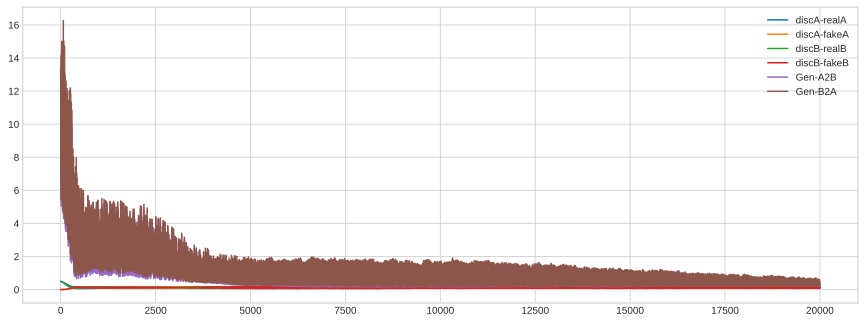

In [27]:
plot_history(discA_loss_realA_hist, discA_loss_fakeA_hist, discB_loss_realB_hist, discB_loss_fakeB_hist, gen_loss_A2B_hist, gen_loss_B2A_hist)

### Synthesise Artificial data with trained CycleGAN

In [28]:
X_syn_scaled1,_ = generate_fake_samples(g_model_AtoB,  Sim_df)
X_synthesised1 = scaler.inverse_transform(X_syn_scaled1)
df_syn1 = pd.DataFrame(data = X_synthesised1, columns = colnames_all)
array_of_hovs = ['CGAN_ASD{}'.format(i) for i in range(len(df_syn1))] # Use List Comprehension to create unique HoV Label for the artificial data point
df_syn1.insert(0, "HoV",array_of_hovs)
df_syn1

,HoV,D,Z,c,V
0,CGAN_ASD0,120.023376,0.309292,1.006241,0.232581
1,CGAN_ASD1,121.636253,0.294898,1.005346,0.238726
2,CGAN_ASD2,123.654694,0.277303,1.004902,0.246333
3,CGAN_ASD3,125.677269,0.259673,1.004459,0.253955
4,CGAN_ASD4,127.704468,0.242003,1.004016,0.261595
5,CGAN_ASD5,129.696091,0.226021,1.002048,0.270496
6,CGAN_ASD6,131.642303,0.212176,0.998155,0.280988
7,CGAN_ASD7,133.674591,0.198602,0.997658,0.292044
8,CGAN_ASD8,135.773666,0.185206,0.999664,0.303534
9,CGAN_ASD9,137.883545,0.171744,1.001685,0.315084


In [0]:
## Saving .csv output dataframe directly in Google Drive
# from google.colab import drive
# drive.mount('drive')
# !cp CycleGAN_ASD_ToyProblem.csv drive/My\ Drive/XYZ/ # Replace XYZ with the folder name which contains this .ipynb file
# df_syn1.to_csv('CycleGAN_ASD_ToyProblem.csv', index = False)

### Data Visualization of Model Output
Create plots of `Diameter` vs `Correction_Factor` for all three datasets

In [0]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file,output_notebook
from bokeh.models import HoverTool
from bokeh.io import show,export_svgs
output_notebook()

In [31]:
p1 = figure(plot_width=1100)
hover = HoverTool(names = ['ActualPoints'],tooltips = [('Diameter (mm)', '@x'), ('Correction Factor','@y')])
hover.point_policy='snap_to_data'

## Add a line renderer - line_dash = 'dashed'
p1.line(dataset_sim['D'],dataset_sim['c'], line_width=2, color="black",line_dash = 'dashed', legend = 'Simulation')
p1.line(df_syn1['D'],df_syn1['c'], line_width=2, color="green", legend = 'CycleGAN_ASD')
p1.line(dataset_LTR['D'],dataset_LTR['c'], line_width=2, color="blue", legend = 'LTR')

## Add a circle renderer with a size, color, and alpha
p1.circle(dataset_sim['D'],dataset_sim['c'], size=12, color="black", alpha=0.85, name = 'ActualPoints',legend = 'Simulation')
p1.circle(dataset_LTR['D'],dataset_LTR['c'], size=12, color="blue", alpha=0.85, name = 'ActualPoints',legend = 'LTR')
p1.circle(df_syn1['D'],df_syn1['c'], size=12, color="green", alpha=0.85, name = 'ActualPoints',legend = 'CycleGAN_ASD')

p1.yaxis.axis_label = "Correction Factor"
p1.xaxis.axis_label = "Diameter (mm)"
p1.legend.location = "top_left" # "bottom_right"
p1.add_tools(hover)

# output_file('plots/CycleGAN_ToyProblem_Dia_Cf.html', mode='inline')
# show the results
show(p1)